## Week 2: TensorFlow introduction

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

This notebook is intended to familiarize you with some basics of TensorFlow, which you'll use extensively in this course. 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots

import tensorflow as tf
from tensorflow import keras

%env TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs

env: TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs


``Tensors``

In [2]:
# Tensors are similar to numpy arrays. They're used to represent inputs and outputs of operations
# You can create tensors from numpy arrays using the convert_to_tensor function

a = np.arange(5)
b = np.ones(5)

a = tf.convert_to_tensor(a)
b = tf.convert_to_tensor(b)

print(a)
print(b)

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int64)
tf.Tensor([1. 1. 1. 1. 1.], shape=(5,), dtype=float64)


In [3]:
# Tensors support similar operations to numpy arrays
# The syntax is a little different

b = tf.cast(b, tf.int64)
a + b

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 3, 4, 5])>

In [4]:
a = np.arange(24)
a = tf.convert_to_tensor(a)
a = tf.reshape(a, [2, 3, 4])
a

<tf.Tensor: shape=(2, 3, 4), dtype=int64, numpy=
array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])>

In [5]:
total = tf.reduce_sum(a)  # similar to numpy.sum
total

<tf.Tensor: shape=(), dtype=int64, numpy=276>

In [6]:
avg = tf.reduce_mean(a, axis=0)
avg

<tf.Tensor: shape=(3, 4), dtype=int64, numpy=
array([[ 6,  7,  8,  9],
       [10, 11, 12, 13],
       [14, 15, 16, 17]])>


Additional material (highly recommended): [Raschka & Mirjalili, Ch 13_part1](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch13/ch13_part1.ipynb)

---

``Models in TF``

We'll be using TensorFlow to train ML models. TensorFlow is a large and complex library, including many constantly evolving functions and APIs (Keras is one set of convenient APIs inside TensorFlow). This means you'll want to learn how to use the documentation and the high-level ideas that guide its design.

The trickiest thing to understand about TensorFlow is primary way in which it differs from standard programming. In a typical program, each line of code is executed sequentially. In TensorFlow, by contrast, you first define a computation graph. The graph specifies how data flows from input to output. However, no computation actually happens until data is passed into the graph and execution begins.

Here's a simple example. Don't worry about understanding the ML details. In a few weeks, you'll understand everything in the code below.

``Read data``

In [7]:
# Note that each example (row) in this dataset describes a patient
df = pd.read_csv(
    'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',
    delimiter='\t'
)

# rename columns
df.columns = [
    'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu', 'disease_progression']

df.head(2)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75


``Split data into training and test``

In [8]:
# define outcome #
##################
y = df['disease_progression'].values

# define features #
###################
X = df[['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']].values

# split #
#########
split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['disease_progression', 'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu']

``Define features of interest``

In [9]:
temp_X_train = X_train[:,2] # choose only BMI
temp_X_test = X_test[:,2]


# exapand dimension so that temp_X_train is a 2D array
temp_X_train = np.expand_dims(temp_X_train, axis=1) 

# exapand dimension so that temp_X_train is a 2D array
temp_X_test = np.expand_dims(temp_X_test, axis=1) 

Define and compile model:

In [10]:
def build_model(num_features):
    """Return a simple linear regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

  # Use Keras Sequential API to build a linear regression model.
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))

    
    # create output layer
    model.add(keras.layers.Dense(
      activation = None,          # linear activation is used
      units=1,                    # there is a single output
      use_bias=True               # include a learned bias parameter
      ))
    

  
  # Use mean squared error as our loss and the Adam optimizer.
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

# Build a model
model = build_model(num_features=temp_X_train.shape[1])

Train model:

In [11]:
# Train model. Hold out 10% of data for validation/test
history = model.fit(
          x=temp_X_train, y=y_train,
          validation_data=[temp_X_test, y_test],
          batch_size=12,
          epochs=50,
          verbose=0
)

In [12]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='test loss') # val_loss is the validation/test data
    plt.xlabel('Epoch')
    plt.ylabel('MSE ("BMI")')
    plt.legend()
    plt.grid(True)

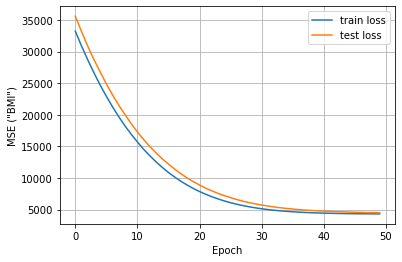

In [13]:
plot_loss(history)

Evaluation

In [14]:
# Run the trained model on the first 10 'BMI' test values
y_train_pred = model.predict(x=temp_X_train[:10]).flatten()
y_train_pred

1/1 [==============================] - 0s 85ms/step


array([145.01099, 135.84189, 135.30254, 133.68446, 132.60574, 196.2501 ,
       169.82152, 188.15973, 144.47165, 158.49496], dtype=float32)

In [15]:
# compare with the actual value for the first 10 'BMI' values
y_train[:10]

array([134, 200,  74, 179, 154, 274, 195, 257,  95, 197])


Check here another example (highly recommended): https://www.tensorflow.org/tutorials/keras/regression

---